In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import os 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='../datasets/mnist_data/', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [9]:
print("using device", device)

using device cuda


In [10]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28) 
        return self.net(x)
        

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

def get_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, device=device)

In [ ]:
num_epochs = 50
noise_dim = 100
os.makedirs('./mnist_basicgan_results', exist_ok=True)
loss_d_list, loss_g_list = [], []

for epoch in range(num_epochs):
    total_loss_d, total_loss_g = 0, 0
    for i, (images, _) in enumerate(train_loader):
        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        discriminator.zero_grad()
        outputs = discriminator(images.to(device)).view(-1, 1)
        loss_d_real = criterion(outputs, real_labels)
        loss_d_real.backward()
        
        z = get_noise(batch_size, noise_dim)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach()).view(-1, 1)
        loss_d_fake = criterion(outputs, fake_labels)
        loss_d_fake.backward()
        
        loss_d = loss_d_fake + loss_d_real
        optimizer_d.step()
        
        generator.zero_grad()
        outputs = discriminator(fake_images).view(-1, 1)
        loss_g = criterion(outputs, real_labels)
        loss_g.backward()
        optimizer_g.step()

        total_loss_d += loss_d.item()
        total_loss_g += loss_g.item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')
    
    total_loss_d /= len(train_loader)
    total_loss_g /= len(train_loader)
    loss_d_list.append(total_loss_d)
    loss_g_list.append(total_loss_g)
        
    fake_images = fake_images.reshape(batch_size, 1, 28, 28)
    if (epoch + 1) % 5 == 0:
        vutils.save_image(fake_images, f'./mnist_basicgan_results/fake_img_epoch_{epoch+1}.png', normalize=True)
        

Epoch [1/50], Step [100/938], Loss D: 0.3100, Loss G: 1.5273
Epoch [1/50], Step [200/938], Loss D: 0.0463, Loss G: 3.9934
Epoch [1/50], Step [300/938], Loss D: 0.0215, Loss G: 12.2892
Epoch [1/50], Step [400/938], Loss D: 2.2396, Loss G: 5.4097
Epoch [1/50], Step [500/938], Loss D: 2.8298, Loss G: 5.8333
Epoch [1/50], Step [600/938], Loss D: 0.1856, Loss G: 2.7725
Epoch [1/50], Step [700/938], Loss D: 0.6472, Loss G: 1.8201
Epoch [1/50], Step [800/938], Loss D: 0.1474, Loss G: 2.8530
Epoch [1/50], Step [900/938], Loss D: 0.4148, Loss G: 2.1409
Epoch [2/50], Step [100/938], Loss D: 0.0558, Loss G: 4.0042
Epoch [2/50], Step [200/938], Loss D: 0.7782, Loss G: 2.5008
Epoch [2/50], Step [300/938], Loss D: 0.0886, Loss G: 7.4533
Epoch [2/50], Step [400/938], Loss D: 0.3357, Loss G: 4.0522
Epoch [2/50], Step [500/938], Loss D: 0.0713, Loss G: 4.2317
Epoch [2/50], Step [600/938], Loss D: 0.2662, Loss G: 3.0643
Epoch [2/50], Step [700/938], Loss D: 0.0733, Loss G: 4.2763
Epoch [2/50], Step [800

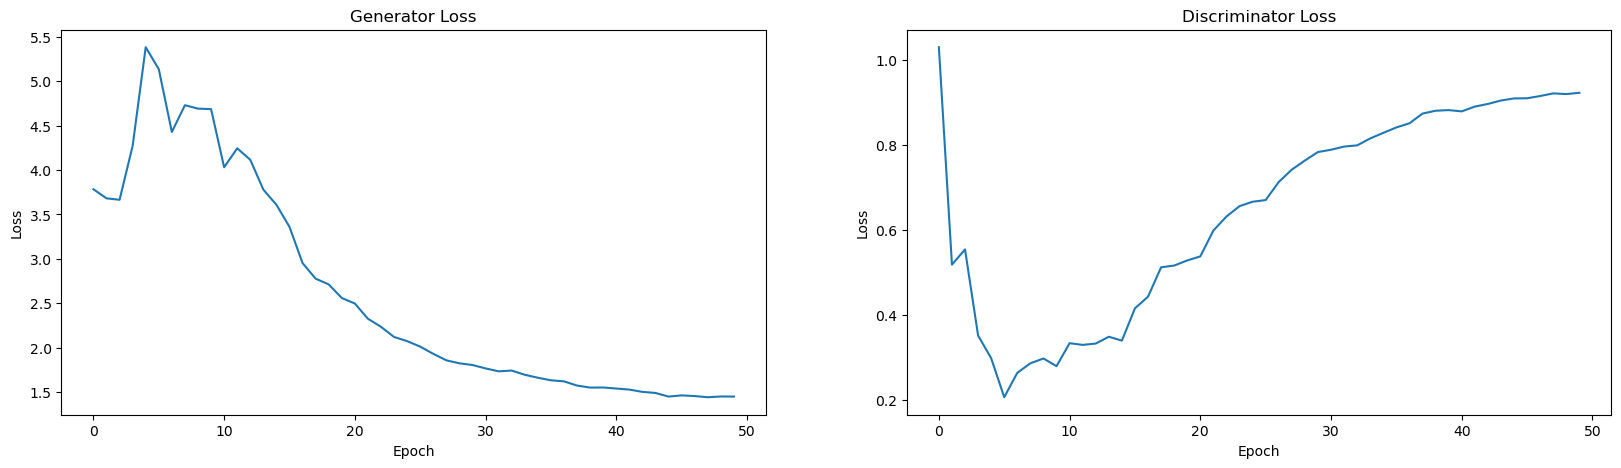

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].set_title('Generator Loss')
axs[0].plot(loss_g_list)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].set_title('Discriminator Loss')
axs[1].plot(loss_d_list)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.show()